# Assignment 2: Naive Bayes Classifier
## Group Members:
* ### Nils Dunlop, e-mail: gusdunlni@student.gu.se
* ### Francisco Alejandro Erazo Piza, e-mail: guserafr@student.gu.se
* ### Chukwudumebi Ubogu, e-mail: gusuboch@student.gu.se

## Preparatory remarks

### Frequency-counting in Python.

In [247]:
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_documents(doc_file):
    """
    Reads a document and returns a list of documents and their corresponding labels.
    """
    docs = []
    labels = []
    categories = []
    with open(doc_file, encoding='utf-8') as f:
        for line in f:
            words = line.strip().split()
            docs.append(words[3:])
            labels.append(words[1])
            categories.append(words[0]) # Used in domain sensitivity section
    return docs, labels, categories

### Reading the review data

In [248]:
def split_data(doc_file, train_split=0.8):
    """
    Splits the data into training and validation sets.
    """
    all_docs, all_labels, all_categories = read_documents(doc_file)
    split_point = int(train_split * len(all_docs))
    train_docs = all_docs[:split_point]
    train_labels = all_labels[:split_point]
    val_docs = all_docs[split_point:]
    val_labels = all_labels[split_point:]
    return train_docs, train_labels, val_docs, val_labels, all_docs, all_labels, all_categories

### Estimating parameters for the Naive Bayes classifier

In [249]:
def train_nb(data, labels):
    """
    Trains a Naive Bayes classifier.
    This function can handle both textual and numerical data.
    """
    # Check if the data is numerical data (DataFrame)
    if isinstance(data, pd.DataFrame):
        model = {}
        unique_labels = data[labels].unique()
        for label in unique_labels:
            class_data = data[data[labels] == label]
            features = class_data.drop(labels, axis=1)
            mean = features.mean(numeric_only=True)
            std = features.std(numeric_only=True)
            model[label] = {'mean': mean, 'std': std}
        return model

    # Otherwise we assume the data is textual data
    else:
        # Initialize counters for each class and a counter for all words
        pos_counter = Counter()
        neg_counter = Counter()
        all_words = set()
    
        # Count word frequencies per class
        for doc, label in zip(data, labels):
            if label == 'pos':
                pos_counter.update(doc)
            elif label == 'neg':
                neg_counter.update(doc)
            all_words.update(doc)
    
        # Total count of words in each class
        total_pos = sum(pos_counter.values())
        total_neg = sum(neg_counter.values())
        V = len(all_words)
    
        # Calculate log probabilities with Laplace smoothing
        log_probs = {}
        for word in all_words:
            # Apply laplace smoothing
            log_prob_pos = np.log((pos_counter[word] + 1) / (total_pos + V))
            log_prob_neg = np.log((neg_counter[word] + 1) / (total_neg + V))
            log_probs[word] = {'pos': log_prob_pos, 'neg': log_prob_neg}
    
        # Calculate the log probabilities of each class
        num_pos = sum(1 for l in labels if l == 'pos')
        num_neg = sum(1 for l in labels if l == 'neg')
        prob_pos = num_pos / len(labels)
        prob_neg = num_neg / len(labels)
        log_prob_pos_class = np.log(prob_pos)
        log_prob_neg_class = np.log(prob_neg)

        if isinstance(data, list):
            model = {
            'word_probs': log_probs,
            'log_prob_class': {'pos': log_prob_pos_class, 'neg': log_prob_neg_class}
            }
        return model

# Splitting the data and then training the model using the training data
train_docs, train_labels, val_docs, val_labels, all_docs, all_labels, all_categories = split_data('reviews.txt')
model = train_nb(train_docs, train_labels)

# Printing first five word probabilities
print("First five word probabilities:")
for word, probabilities in list(model['word_probs'].items())[:5]:
    print(f"{word}: {probabilities}")

# Printing class log probabilities
print("\nClass log probabilities:")
for class_label, log_prob in model['log_prob_class'].items():
    print(f"{class_label}: {log_prob}")

First five word probabilities:
rubin-directed: {'pos': -12.865259652006523, 'neg': -13.55064356428109}
geller: {'pos': -12.865259652006523, 'neg': -13.55064356428109}
afeni: {'pos': -13.558406832566469, 'neg': -12.857496383721145}
duracells: {'pos': -13.558406832566469, 'neg': -12.857496383721145}
shirley: {'pos': -11.948968920132367, 'neg': -11.06573691449309}

Class log probabilities:
pos: -0.6761896870922498
neg: -0.7103971982200179


### Classifying new documents

In [250]:
def score_doc_label(document, label, model):
    """
    Computes the logarithm probability of observing a document given a label.
    This function can handle both textual and numerical data.
    """
    if 'mean' in model.get(label, {}):
        # Numerical data scoring
        mean = model[label]['mean']
        std = model[label]['std']
        log_prob = 0
        for i in range(len(document)):
            feature_value = document[i]
            feature_mean = mean[i]
            feature_std = std[i]
            log_prob += np.log(1 / (np.sqrt(2 * np.pi) * feature_std)) - 0.5 * ((feature_value - feature_mean) ** 2 / (feature_std ** 2))
        return log_prob
    else:
        # Textual data scoring
        log_prob_class = model['log_prob_class']
        log_prob = log_prob_class[label]
        word_probs = model['word_probs']
        for word in document:
            if word in word_probs:
                log_prob += word_probs[word].get(label, 0)
            else:
                pass  # Unseen word we choose to ignore it
        return log_prob

In [251]:
# Sanity Check 1: Testing with the word "great"
log_prob_pos_great = score_doc_label(["great"], "pos", model)
log_prob_neg_great = score_doc_label(["great"], "neg", model)
prob_pos_great = np.exp(log_prob_pos_great)
prob_neg_great = np.exp(log_prob_neg_great)

# Sanity Check 2: Testing with the word "bad"
log_prob_pos_bad = score_doc_label(["bas"], "pos", model)
log_prob_neg_bad = score_doc_label(["bas"], "neg", model)
prob_pos_bad = np.exp(log_prob_pos_bad)
prob_neg_bad = np.exp(log_prob_neg_bad)

# Sanity Check 3: Testing with the document ['a', 'top-quality', 'performance']
log_prob_pos_doc = score_doc_label(['a', 'top-quality', 'performance'], "pos", model)
log_prob_neg_doc = score_doc_label(['a', 'top-quality', 'performance'], "neg", model)

prob_pos_great, prob_neg_great, prob_pos_bad, prob_neg_bad, log_prob_pos_doc, log_prob_neg_doc

(0.0013212141496043825,
 0.0005283997934747295,
 0.5085510439618088,
 0.49144895603819116,
 -12.807858361140351,
 -13.486891735775352)

In [252]:
def classify_nb(document, model):
    """
    Classify a new document using the Naive Bayes classifier.
    """
    # Compute the log probability for each class
    log_prob_pos = score_doc_label(document, "pos", model)
    log_prob_neg = score_doc_label(document, "neg", model)

    # Return the class with the higher log probability
    if log_prob_pos > log_prob_neg:
        return "pos"
    else:
        return "neg"

In [253]:
# Sanity checks on small test documents
test_docs = [["great"], ["bad"], ["amazing"], ["terrible"], ['a', 'top-quality', 'performance']]

# Applying the classify_nb function to the test documents
classified_docs = []
for doc in test_docs:
    classification = classify_nb(doc, model)
    classified_docs.append((doc, classification))

classified_docs

[(['great'], 'pos'),
 (['bad'], 'neg'),
 (['amazing'], 'pos'),
 (['terrible'], 'neg'),
 (['a', 'top-quality', 'performance'], 'pos')]

### Evaluating the classifier

In [254]:
def classify_documents(docs, model):
    """
    Classifies documents in the provided collection.
    """
    predictions = []
    for doc in docs:
        prediction = classify_nb(doc, model)
        predictions.append(prediction)
    return predictions

In [255]:
def accuracy(true_labels, guessed_labels):
    """
    Computes the accuracy of the classifier.
    """
    correct_count = 0

    for t, g in zip(true_labels, guessed_labels):
        if t == g:
            correct_count += 1
    
    acc = correct_count / len(true_labels)
    return acc

In [256]:
def precision_recall_f1(true_labels, predicted_labels):
    """
    Compute precision, recall, and F1 score.
    """
    # Initialize variables
    true_positives, false_positives, false_negatives = 0, 0, 0

    # Counting true positives, false positives, and false negatives
    for true, pred in zip(true_labels, predicted_labels):
        if true == 'pos' and pred == 'pos':
            true_positives += 1
        elif true == 'neg' and pred == 'pos':
            false_positives += 1
        elif true == 'pos' and pred == 'neg':
            false_negatives += 1

    # Calculating precision, recall, and F1 score
    precision, recall, f1 = 0, 0, 0

    if true_positives + false_positives > 0:
        precision = true_positives / (true_positives + false_positives)

    if true_positives + false_negatives > 0:
        recall = true_positives / (true_positives + false_negatives)

    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

In [257]:
# Calculating the accuracy, precision, recall, and F1 score
predicted_labels = classify_documents(val_docs, model)
accuracy_result = accuracy(val_labels, predicted_labels)
precision, recall, f1_score = precision_recall_f1(val_labels, predicted_labels)

print(f"\nAccuracy: {accuracy_result} \nPrecision: {precision}\nRecall: {recall}\nF1 score: {f1_score}")


Accuracy: 0.8153587914393622 
Precision: 0.8237965485921889
Recall: 0.7866435385949696
F1 score: 0.8047914818101153


### What is the difference between F1 score and accuracy?

**Accuracy**
Accuracy is a measures the proportion of correctly predicted instances out of all the predictions made. In short, it is the number of correct predictions divided by the total number of predictions. Accuracy gives us a general idea of how well the model is performing.

**Precision**
F1 score is a slightly more nuanced metric. It is the harmonic mean of precision and recall. Precision is the ratio of true positives to all positive predictions. Recall is the ratio of true positives to all actual positive instances. F1 score balances precision and recall, providing a more holistic view of how well the model is performing especially when the classes are imbalanced.

### Error Analysis
We analyzed the first 10 documents and their corresponding prediction. Below you will see three instances which were harder to predict: 
 
1. Document about an Iron **(Predicted: Negative)**:

* Content: The document starts with a warning not to buy the iron, mentions it's fabulous when it works, but then highlights that it broke in less than a week and had other issues.
* Analysis: The prediction as negative seems correct. The initial positive remark "it's fabulous" probably was outweighed by the predominantly negative context.

2. Document about Madame Bovary **(Predicted: Positive)**:
* Content: The review seems to be more about the characters in the story, with a mix of critique and appreciation for the adaptation and performances.
* Analysis: This document was tricky to label as it wrote polarizing thoughts about the book. We assume that the classifier picked up on more positive aspects than negative aspects of the book, leading to a positive prediction. 

3. Document about Microsoft Office **(Predicted: Negative)**:
* Content: The reviewer criticizes the new interface of Microsoft Office, finding it infuriating and less efficient.
* Analysis: The negative prediction aligns with the strong criticism expressed in the document.

Overall the classifier seemed to predict well the sentiment expressed in the first 10 documents. The more challenging cases for the classifier could be the ones with mixed sentiments or when the sentiment is expressed in a not so straightforward way such as the Madame Bovary document.

### Cross-validation

In [258]:
def cross_validation_10_fold(all_docs, all_labels, N=10):
    """
    Performs 10-fold cross-validation. 
    """
    accuracy_scores = []
    for fold_nbr in range(N):
        split_point_1 = int(float(fold_nbr)/N*len(all_docs))
        split_point_2 = int(float(fold_nbr+1)/N*len(all_docs))

        train_docs_fold = all_docs[:split_point_1] + all_docs[split_point_2:]
        train_labels_fold = all_labels[:split_point_1] + all_labels[split_point_2:]
        val_docs_fold = all_docs[split_point_1:split_point_2]
        val_labels_fold = all_labels[split_point_1:split_point_2]

        model = train_nb(train_docs_fold, train_labels_fold)
        predicted_labels = classify_documents(val_docs_fold, model)
        accuracy_scores.append(accuracy(val_labels_fold, predicted_labels))

    return sum(accuracy_scores) / N

In [259]:
def cross_validation_loocv(all_docs, all_labels, max_iterations=100):
    """
    Performs leave-one-out cross-validation. 
    """
    accuracy_scores = []
    for i in range(min(max_iterations, len(all_docs))):
        train_docs_fold = all_docs[:i] + all_docs[i+1:]
        train_labels_fold = all_labels[:i] + all_labels[i+1:]
        val_docs_fold = [all_docs[i]]
        val_labels_fold = [all_labels[i]]

        model = train_nb(train_docs_fold, train_labels_fold)
        predicted_labels = classify_documents(val_docs_fold, model)
        accuracy_scores.append(accuracy(val_labels_fold, predicted_labels))

    return sum(accuracy_scores) / len(accuracy_scores)

In [260]:
# 10-Fold Cross-Validation
avg_accuracy_10_fold = cross_validation_10_fold(all_docs, all_labels, N=10)
print("Average Accuracy (10-Fold Cross-Validation):", avg_accuracy_10_fold)

# LOOCV
avg_accuracy_loocv = cross_validation_loocv(all_docs, all_labels, max_iterations=100)
print("Average Accuracy (LOOCV, first 100 iterations):", avg_accuracy_loocv)

Average Accuracy (10-Fold Cross-Validation): 0.8076216900805256
Average Accuracy (LOOCV, first 100 iterations): 0.83


### Cross-validation results
* **10-Fold Cross-Validation**: Achieved an average accuracy of about 0.808. This method offers a balanced evaluation, as it trains and validates across different subsets of the data resulting in a consistent classifier performance.
* **LOOCV (100 Iterations)**: Showed a slightly higher average accuracy of 0.83. By training on nearly all available data for each test case, this method offers a more accurate evaluation of the classifier performance. However, it is computationally expensive and can be slow to run.

The 10-fold and LOOCV results indicate a reliable classifier, with 10-fold offering a broader accuracy measure and LOOCV providing more detailed validation, however with higher computational demands.

### Domain sensitivity

In [261]:
def filter_by_category(docs, labels, categories, category_name):
    """
    Filters the reviews by a specific category.
    """
    filtered_docs = []
    filtered_labels = []

    for doc, label, cat in zip(docs, labels, categories):
        if cat == category_name:
            filtered_docs.append(doc)
            filtered_labels.append(label)

    return filtered_docs, filtered_labels

In [262]:
# Filter documents by category
camera_docs, camera_labels = filter_by_category(all_docs, all_labels, all_categories, 'camera')
book_docs, book_labels = filter_by_category(all_docs, all_labels, all_categories, 'books')

#### Split the data into training and validation sets

In [263]:
def split_pre_filtered_data(docs, labels, train_split=0.8):
    """
    Split the filtered documents and labels into training and validation sets.
    """
    split_point = int(train_split * len(docs))
    train_docs = docs[:split_point]
    train_labels = labels[:split_point]
    val_docs = docs[split_point:]
    val_labels = labels[split_point:]
    return train_docs, train_labels, val_docs, val_labels

In [264]:
camera_train_docs, camera_train_labels, camera_val_docs, camera_val_labels = split_pre_filtered_data(camera_docs, camera_labels)
book_train_docs, book_train_labels, book_val_docs, book_val_labels = split_pre_filtered_data(book_docs, book_labels)

### Train the classifier on the camera and book reviews

In [266]:
# Train classifier for camera reviews
camera_model= train_nb(camera_train_docs, camera_train_labels)

# Evaluate classifier on camera validation set
camera_predicted_labels = classify_documents(camera_val_docs, camera_model)
camera_accuracy = accuracy(camera_val_labels, camera_predicted_labels)

# Train classifier for book reviews
book_model = train_nb(book_train_docs, book_train_labels)

# Evaluate classifier on book validation set
book_predicted_labels = classify_documents(book_val_docs, book_model)
book_accuracy = accuracy(book_val_labels, book_predicted_labels)

# Evaluate the classifiers on the opposite domain
camera_on_book_accuracy = accuracy(book_val_labels, classify_documents(book_val_docs, camera_model))
book_on_camera_accuracy = accuracy(camera_val_labels, classify_documents(camera_val_docs, book_model))

# Show the results
print(f"Camera Classifier on Camera Reviews Accuracy: {camera_accuracy}")
print(f"Book Classifier on Book Reviews Accuracy: {book_accuracy}")
print(f"Camera Classifier on Book Reviews Accuracy: {camera_on_book_accuracy}")
print(f"Book Classifier on Camera Reviews Accuracy: {book_on_camera_accuracy}")

Camera Classifier on Camera Reviews Accuracy: 0.8675
Book Classifier on Book Reviews Accuracy: 0.7925
Camera Classifier on Book Reviews Accuracy: 0.71
Book Classifier on Camera Reviews Accuracy: 0.65


### Classifier Performance Analysis
#### Within-Domain Accuracy
* **Camera Classifier on Camera Reviews**: Achieved an accuracy of 0.8675. The high accuracy indicates that the classifier is well-tuned to the specific features and patterns present in camera reviews. 
* **Book Classifier on Book Reviews**: Accomplished an accuracy of 0.7925. While slightly lower than the camera classifier, it still shows a strong performance suggesting a good model fit to book review data.

#### Cross-Domain Accuracy
* **Camera Classifier on Book Reviews**: The accuracy dropped to 0.71 when the camera classifier was applied to book reviews. This significant drop in accuracy highlights the domain sensitivity. In turn indicating that features learned from camera reviews are not as effective in classifying book reviews.
* **Book Classifier on Camera Reviews**: Saw an even further drop in accuracy to 0.65. Similarly to the camera classifier, the book classifier was not able to generalize well to the camera reviews.

#### Conclusion
The results demonstrate a clear importance of domain sensitivity. Both classifiers perform well within their respective domains showing that they have learned domain-specific features effectively. However, when applied to a different domain their accuracy drops significantly demonstrating the importance of domain-specific language and features in text classification tasks. 


### Naive Bayes for numerical data

In [267]:
# Read the data
df = pd.read_csv('iris.csv')

In [268]:
# Train the model
model = train_nb(df, 'species')

predictions = []

# Iterate over the rows in the dataframe
for index, row in df.iterrows():
    iris_document = row.drop('species').tolist()
    
    # Compute the log probability for each class
    log_probs = {label: score_doc_label(iris_document, label, model) for label in model}
    predicted_class = max(log_probs, key=log_probs.get)
    predictions.append(predicted_class)

# Add the predictions to the dataframe
df['predicted_species'] = predictions
df['correct_prediction'] = df['species'] == df['predicted_species']

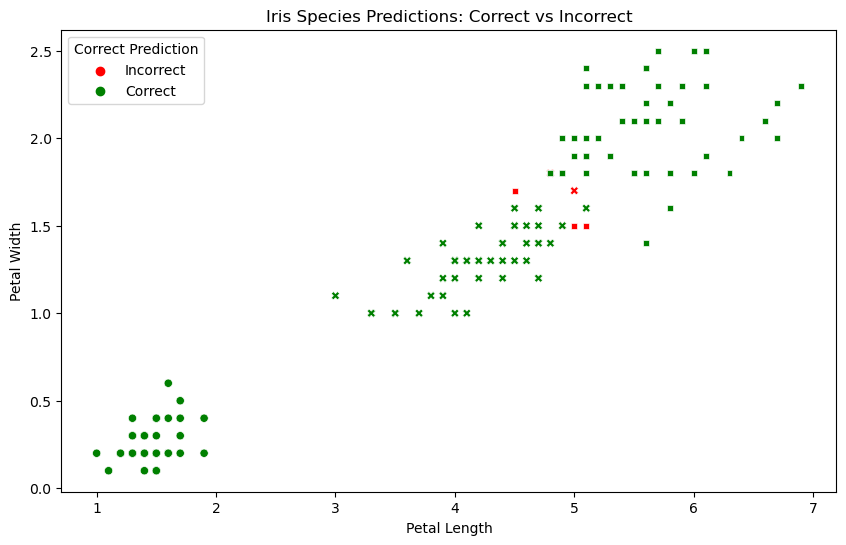

In [269]:
# Plot the correct and incorrect predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='petal_length', y='petal_width', hue='correct_prediction', style='species', palette={True: "green", False: "red"})
plt.title('Iris Species Predictions: Correct vs Incorrect')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
handles, _ = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles[1:], labels=['Incorrect', 'Correct'], title='Correct Prediction', loc='upper left')
plt.show()

## References:
* Add 1 (Laplace) Smoothing: https://courses.engr.illinois.edu/cs447/fa2018/Slides/Lecture04.pdf